In [1]:
import numpy as np
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.base import ClassifierMixin
from scipy.sparse import coo_matrix

xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X = rng.randn(300, 2)
y = np.array(np.logical_xor(X[:, 0] > 0, X[:, 1] > 0), 
             dtype=int)


def generate_sample(n=10):
    X = rng.randn(n, 2)
    y = np.array(np.logical_xor(X[:, 0] > 0, X[:, 1] > 0), 
             dtype=int)
    return X, y

In [2]:
%matplotlib inline

In [3]:
class DecisionNode(ClassifierMixin):
    def __init__(self, delta=0.05, min_seen=100):
        self.proposal_scores = None
        self.n_seen = 0 
        self.delta = delta
        self.min_seen = min_seen
        self.base_node = GaussianNB()
        self.proposal_scores = None
        self.n_seen = 0
        self.feat = None
        self.val = None
        self.impurity = None
        self.is_split = False
        self.left = None
        self.right = None

    def fit(self, X, y):
        self.proposal_scores = None
        self.n_seen = 0
        self.feat = None
        self.val = None
        self.impurity = None
        self.is_split = False
        return self.partial_fit(X, y)
    
    def hoeffding_bound(self, n):
        return np.sqrt(0.25 * np.log(1 / self.delta) / (2 * n))
    
    def split_dataset(self, X, y):
        if self.is_split:
            y_indx = X[:, self.feat] < self.val
            return [
                (X[y_indx, :], y[y_indx]),
                (X[~y_indx, :], y[~y_indx])
            ]
        else:
            return None
        
    
    def partial_fit(self, X, y):
        if self.n_seen == 0:
            self.base_node.fit(X, y)
        else:
            self.base_node.partial_fit(X, y)
            
        self.n_seen += X.shape[0]
        
        proposed_splits = np.mean(self.base_node.theta_, 0)
        if self.proposal_scores is None:
            self.proposal_scores = np.zeros(X.shape[1])
        for feat_idx in range(X.shape[1]):
            y_indx = X[:, feat_idx] < proposed_splits[feat_idx]
            self.proposal_scores[feat_idx] += np.sum(y[y_indx])
            
        impurity = [
            2 * (x / self.n_seen) * (1 - x / self.n_seen) for x in self.proposal_scores
        ]
        
        vals = sorted(impurity.copy())[:2]
        is_split = False
        split_info = None
        if not self.is_split and np.abs(vals[0] - vals[1]) < self.hoeffding_bound(self.n_seen) and self.n_seen >= self.min_seen:
            self.is_split = True
            self.feat = np.argmin(impurity)
            self.val = proposed_splits[self.feat]
            y_indx = X[:, self.feat] < proposed_splits[self.feat]
        elif self.is_split:
            self.val = proposed_splits[self.feat]
        return self
    
    def predict(self, X):
        return self.base_node.predict(X)

In [4]:
class VFDT(ClassifierMixin):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.root = DecisionNode(**kwargs)
        
   
    def fit(self, X, y):
        return self.partial_fit(X, y)
    
    def partial_fit_(self, node, X, y):
        node = node.partial_fit(X, y)
        if node.is_split and node.left is None and node.right is None:
            node.left = DecisionNode(**self.kwargs)
            node.right = DecisionNode(**self.kwargs)
            left_data, right_data = node.split_dataset(X, y)
            node.left = self.partial_fit_(node.left, *left_data)
            node.right = self.partial_fit_(node.right, *right_data)
        elif node.is_split:
            left_data, right_data = node.split_dataset(X, y)
            node.left = self.partial_fit_(node.left, *left_data)
            node.right = self.partial_fit_(node.right, *right_data)
            
        return node
    
    def partial_fit(self, X, y):
        self.root = self.partial_fit_(self.root, X, y)
        return self
    
    def predict_(self, node, X, indx):
        if node.is_split:
            left_data, right_data = node.split_dataset(X, indx)
            pred_left = self.predict_(node.left, *left_data)
            pred_right = self.predict_(node.right, *right_data)
            return [pred_left, pred_right]
        else:
            return (node.predict(X), indx)
    
    def predict(self, X):
        pred = self.predict_(self.root, X, np.arange(X.shape[0]))
        if type(pred) is tuple:
            return pred[0]
        return self.convert_to_array(pred, X).flatten()
    
    def convert_to_array(self, pred, X):
        row = []
        col = []
        data = []
        for p in pred:
            row.extend(p[1])
            data.extend(p[0])
            col.extend(p[0]*0)
        return coo_matrix((data, (row, col)), shape=(X.shape[0], 1)).toarray()

In [5]:
vfdt = VFDT()

In [6]:
X1, y1 = generate_sample()
vfdt.fit(X1, y1)

   
for _ in range(100):
    X1, y1 = generate_sample(100)
    vfdt.partial_fit(X1, y1)

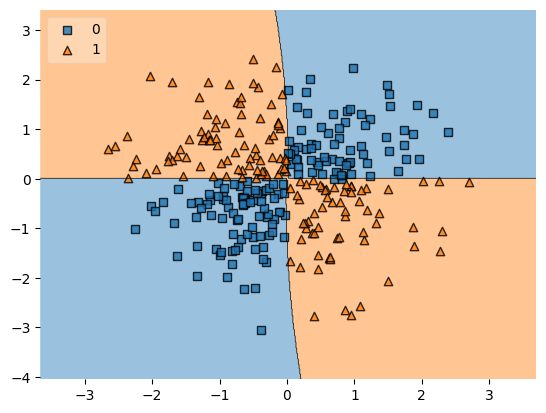

In [7]:
fig = plot_decision_regions(X=X, y=y, clf=vfdt, legend=2)